In [ ]:
# Grundlegende Bibliotheken
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import numpy as np
import missingno as msno

# Einstellungen für bessere Plots
plt.rcParams['figure.figsize'] = (10, 6)

# Pandas Optionen
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Download latest version

path = kagglehub.dataset_download("priyamchoksi/credit-card-transactions-dataset")

ds = pd.read_csv(f"{path}/credit_card_transactions.csv")

print(f"Anzahl Zeilen: {ds.shape[0]}")
print(f"Anzahl Spalten: {ds.shape[1]}")

/Users/philsolenthaler 1/Documents/Universität/BCS/3.Semester/Statistik/DatenbankenProjetk/Statistik-Datenbank/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Anzahl Zeilen: 1296675
Anzahl Spalten: 24


## **Aufgestellte Hypothesen**:
* Fraud-Transaktionen haben im Mittel einen höheren Transaktionsbetrag als Non-Fraud-Transaktionen*
* Fraud-Transaktionen sind häufiger online (statt POS) als Non-Fraud
* Fraud-Transaktionen treten signifikant häufiger nachts auf als reguläre Transaktionen.
* Fraud-Kunden haben im Schnitt mehr Transaktionen in kurzer Zeitspanne („Bursting Behavior“) als Non-Fraud-Kunden.
* Ein bestimmter Kundentyp (z. B. Altersgruppen, Kundensegmente) weist mehr Fraud-Fälle auf.
* Bestimmte Categories weisen höhere Fraud-Raten auf.


## 1. Hypothese: Transaktionsbetrag (Amount)
#### Fragestellung: Unterscheidet sich der durchschnittliche Betrag bei Betrugsfällen signifikant von regulären Transaktionen?

Nullhypothese $H_0$ : μ fraud=μ non_fraud (Die Mittelwerte sind gleich).

Alternativhypothese $H_1$: μ fraud >μ non_fraud (Betrugsfälle haben höhere Beträge).


#### Durchführung (T-Test)

Der T-Test wurde gewählt, um zu prüfen, ob der Unterschied zwischen den Durchschnittsbeträgen von Betrugsfällen und regulären Transaktionen statistisch signifikant ist.

Da die Beträge oft rechtsschief sind, nutzen wir für den Test die log-transformierten Daten (fraud_log), um die Normalverteilung besser zu approximieren.

/var/folders/cd/nv3twvx12gx_b15k3sbqkn300000gn/T/ipykernel_45558/3491826981.py:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(nonfraud_amounts, label="Non-Fraud", shade=True)
/var/folders/cd/nv3twvx12gx_b15k3sbqkn300000gn/T/ipykernel_45558/3491826981.py:25: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fraud_amounts, label="Fraud", shade=True)
/var/folders/cd/nv3twvx12gx_b15k3sbqkn300000gn/T/ipykernel_45558/3491826981.py:36: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(nonfraud_log, label="Non-Fraud (log)", shade=True)
/var/folders/cd/nv3twvx12gx_b15k3sbqkn300000gn/T/ipykernel_45558/3491826981.py:37: FutureWarning: 


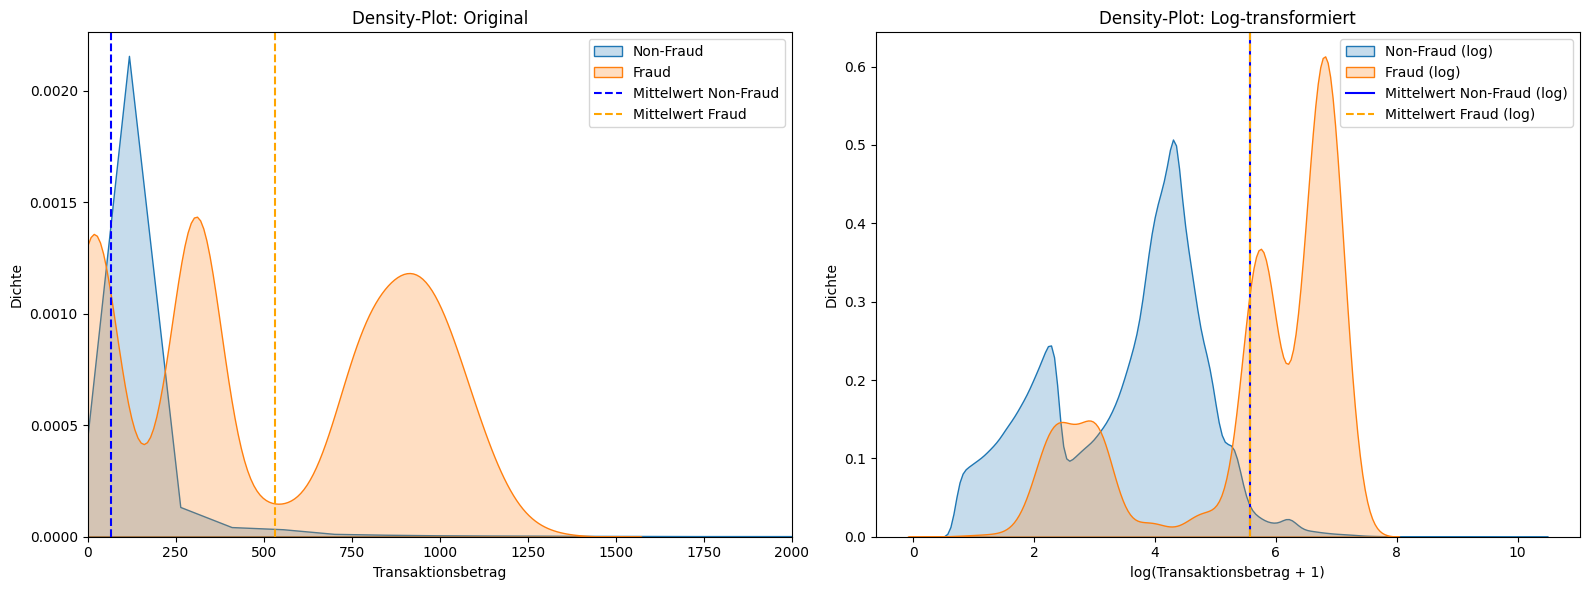

t-Statistik: 102.80470607258108
Einseitiger p-Wert: 0.0
H1 angenommen: Fraud-Transaktionen haben im Mittel höhere Beträge.


In [ ]:
from scipy.stats import ttest_ind
from scipy.stats import norm

# Daten laden
fraud_amounts = ds[ds["is_fraud"] == 1]["amt"]
nonfraud_amounts = ds[ds["is_fraud"] == 0]["amt"]

# Log-Transformation
fraud_log = np.log1p(fraud_amounts)
nonfraud_log = np.log1p(nonfraud_amounts)

# Mittelwerte berechnen
mean_nonfraud = nonfraud_amounts.mean()
mean_fraud = fraud_amounts.mean()
mean_nonfraud_log = fraud_log.mean()
mean_fraud_log = fraud_log.mean()

plt.figure(figsize=(16, 6))

# Linker Plot: Original Beträge
plt.subplot(1, 2, 1)
sns.kdeplot(nonfraud_amounts, label="Non-Fraud", shade=True)
sns.kdeplot(fraud_amounts, label="Fraud", shade=True)
plt.axvline(mean_nonfraud, color='blue', linestyle='--', label='Mittelwert Non-Fraud')
plt.axvline(mean_fraud, color='orange', linestyle='--', label='Mittelwert Fraud')
plt.xlabel("Transaktionsbetrag")
plt.ylabel("Dichte")
plt.title("Density-Plot: Original")
plt.xlim(0,2000)
plt.legend()

# Rechter Plot: Log-transformierte Beträge
plt.subplot(1, 2, 2)
sns.kdeplot(nonfraud_log, label="Non-Fraud (log)", shade=True)
sns.kdeplot(fraud_log, label="Fraud (log)", shade=True)
plt.axvline(mean_nonfraud_log, color='blue', linestyle='-', label='Mittelwert Non-Fraud (log)')
plt.axvline(mean_fraud_log, color='orange', linestyle='--', label='Mittelwert Fraud (log)')
plt.xlabel("log(Transaktionsbetrag + 1)")
plt.ylabel("Dichte")
plt.title("Density-Plot: Log-transformiert")
plt.legend()

plt.tight_layout()
plt.show()

# t-Test durchführen
t_stat, p_two_sided = ttest_ind(fraud_amounts, nonfraud_amounts, equal_var=False)
if t_stat > 0:
    p_one_sided = p_two_sided / 2
else:
    p_one_sided = 1 - (p_two_sided / 2)

print("t-Statistik:", t_stat)
print("Einseitiger p-Wert:", p_one_sided)

alpha = 0.05
if p_one_sided < alpha:
    print("H1 angenommen: Fraud-Transaktionen haben im Mittel höhere Beträge.")
else:
    print("H0 kann nicht verworfen werden.")

### Interpretation

#### Interpretation der t-Statistik 

Die extrem hohe t-Statistik (102.8) zeigt, dass der Unterschied zwischen den Gruppen massiv über dem liegt, was durch reinen Zufall zu erwarten wäre. Sie signalisiert eine sehr starke Trennschärfe zwischen den beiden Kategorien.

#### Interpretation des p-Werts 

Ein p-Wert von nahezu Null bedeutet, dass die Wahrscheinlichkeit für einen Zufallsbefund praktisch ausgeschlossen ist. Damit wird die Nullhypothese sicher verworfen und die Alternativhypothese ($H_1$) bestätigt.

#### Schlussfolgerung

Die Analyse beweist statistisch, dass Betrugsfälle im Durchschnitt deutlich höhere Beträge aufweisen als normale Transaktionen. Für die Praxis bedeutet dies, dass die Höhe des Betrags eines der wichtigsten Merkmale (Features) zur Identifizierung von Betrug ist.


## 2. Hypothese: Transaktionskanal (Online vs Offline)

#### Fragestellung: Sind Betrugstransaktionen im Online-Kanal häufiger vertreten als bei physischen Verkaufsstellen (POS)?

Nullhypothese $H_0$ : Es gibt keinen Zusammenhang zwischen dem Kanal (Online/Offline) und dem Betrugsstatus (Die Variablen sind unabhängig).

Alternativhypothese $H_1$: Online-Transaktionen weisen eine signifikant höhere Wahrscheinlichkeit für Betrug auf als Offline-Transaktionen.


#### Durchführung (Chi-Quadrat-Test)

Der Chi-Quadrat-Unabhängigkeitstest wurde gewählt, um den Zusammenhang zwischen zwei kategorialen Variablen (Kanal und Betrugsstatus) zu prüfen. Zusätzlich berechnen wir die Odds Ratio, um das relative Risiko quantifizierbar zu machen.

is_fraud       0     1
channel               
offline   317129  2836
online    203520  2762
Chi2: 243.6874284262562
p-value: 0.0000
Odds Ratio: 1.5175615409969307


/var/folders/cj/7vlgj44s1rv8_1ymt1nm1qpm0000gp/T/ipykernel_15202/2157718307.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='channel', y='fraud_rate', data=fraud_rate, palette='Set2')


(0.0, 0.023389437759959667)

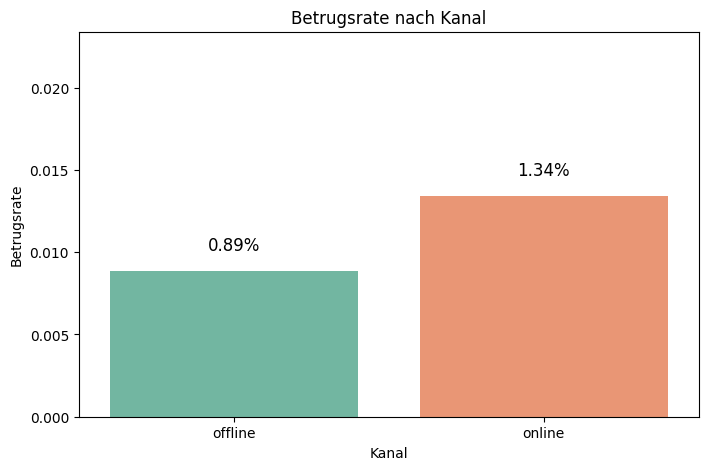

In [6]:
from scipy.stats import chi2_contingency

ds_filtered = ds[ds['category'].str.endswith(('_net', '_pos'))].copy()
ds_filtered['channel'] = np.where(ds_filtered['category'].str.endswith('_net'), 'online', 'offline')


contingency_table = pd.crosstab(ds_filtered['channel'], ds_filtered['is_fraud'])
print(contingency_table)

chi2, p, dof, expected = chi2_contingency(contingency_table)
print("Chi2:", chi2)
print(f"p-value: {p:.4f}")

a = contingency_table.loc['online', 1]      # Fraud online
b = contingency_table.loc['offline', 1]     # Fraud offline
c = contingency_table.loc['online', 0]      # Non-Fraud online
d = contingency_table.loc['offline', 0]     # Non-Fraud offline

odds_ratio = (a / b) / (c / d)
print("Odds Ratio:", odds_ratio)

# Betrugsrate pro Kanal (bereits berechnet)
fraud_rate = ds_filtered.groupby('channel')['is_fraud'].mean().reset_index()
fraud_rate.rename(columns={'is_fraud': 'fraud_rate'}, inplace=True)

plt.figure(figsize=(8,5))
sns.barplot(x='channel', y='fraud_rate', data=fraud_rate, palette='Set2')

# Werte annotieren
for i, row in fraud_rate.iterrows():
    plt.text(i, row['fraud_rate'] + 0.001, f"{row['fraud_rate']*100:.2f}%", 
             ha='center', va='bottom', fontsize=12)

plt.title("Betrugsrate nach Kanal")
plt.ylabel("Betrugsrate")
plt.xlabel("Kanal")
plt.ylim(0, fraud_rate['fraud_rate'].max() + 0.01)

### Interpretation

#### Interpretation der Chi^2-Statistik

Der hohe Wert von ca. 243,7 zeigt eine massive Abweichung von der Unabhängigkeit; die Verteilung des Betrugs ist also stark vom Kanal abhängig.

#### Interpretation des p-Werts 

Ein p-Wert von nahezu Null bestätigt, dass der Zusammenhang statistisch höchst signifikant ist und kein Zufallsprodukt darstellt.

#### Interpretation des Odds Ratio

Der Wert von 1,52 besagt, dass die Chance für einen Betrug im Online-Kanal um etwa 52 % höher ist als im Offline-Kanal.

#### Schlussfolgerung

Online-Transaktionen sind risikoreicher. Der Kanal ist somit ein wesentlicher Indikator für Betrugserkennungssysteme, um Sicherheitsprüfungen gezielter zu steuern.

## 3. Hypothese: Geschlecht

#### Fragestellung: Unterscheidet sich der Anteil an Betrugsfällen zwischen Frauen und Männern signifikant?

Nullhypothese $H_0$ : Der Anteil an Fraud-Transaktionen ist bei Frauen und Männern gleich

Alternativhypothese $H_1$: Der Anteil an Fraud-Transaktionen unterscheidet sich zwischen Frauen und Männern


#### Durchführung (Permutationstest & Chi-Quadrat)

Um die Robustheit zu gewährleisten, wurde ein Permutationstest (5'000 Iterationen) durchgeführt, der unabhängig von Verteilungsannahmen die Signifikanz der Differenz prüft. Ergänzend wurden der Chi-Quadrat-Test für die Unabhängigkeit sowie die Odds Ratio und Cramér's V zur Bestimmung der Effektstärke berechnet.

In [ ]:
# Gruppen
group_M = ds[ds['gender'] == 'M']['is_fraud'].values
group_F = ds[ds['gender'] == 'F']['is_fraud'].values

# Beobachtete Differenz berechnen
observed_diff = group_F.mean() - group_M.mean()
print("Beobachtete Differenz (F-M):", observed_diff)

# Labels mischen und neue Differenzen berechnen
all_data = np.concatenate([group_M, group_F])
n_B = len(group_F)
n_permutations = 5000
perm_diffs = np.zeros(n_permutations)

for i in range(n_permutations):
    np.random.shuffle(all_data)
    perm_F = all_data[:n_B]
    perm_M = all_data[n_B:]
    perm_diffs[i] = perm_F.mean() - perm_M.mean()

# p-Wert berechnen (zweiseitig)
p_value = np.mean(np.abs(perm_diffs) >= np.abs(observed_diff))
print("Permutationstest p-Wert (zweiseitig):", p_value)

if p_value < 0.05:
    print("Signifikanter Unterschied zwischen F und M")
else:
    print("Kein signifikanter Unterschied")



Beobachtete Differenz (F-M): -0.0011646703093246774
Permutationstest p-Wert (zweiseitig): 0.0
Signifikanter Unterschied zwischen F und M


/var/folders/cd/nv3twvx12gx_b15k3sbqkn300000gn/T/ipykernel_45558/3892053491.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


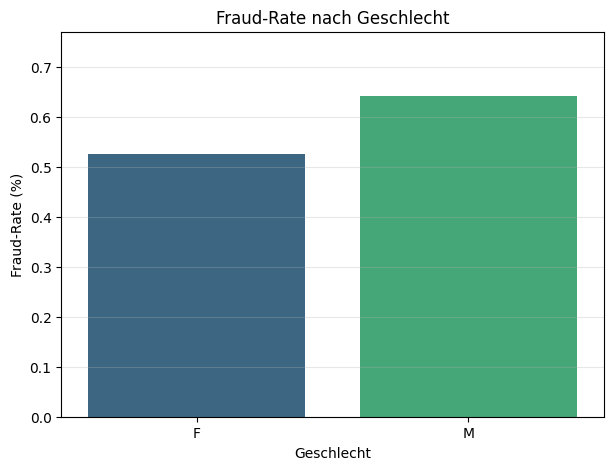

In [ ]:
fraud_rate_gender = ds.groupby("gender")["is_fraud"].mean().reset_index()
fraud_rate_gender["is_fraud"] = fraud_rate_gender["is_fraud"] * 100 

plt.figure(figsize=(7,5))
sns.barplot(
    data=fraud_rate_gender,
    x="gender",
    y="is_fraud",
    palette="viridis"
)
plt.ylabel("Fraud-Rate (%)")
plt.xlabel("Geschlecht")
plt.title("Fraud-Rate nach Geschlecht")
plt.ylim(0, fraud_rate_gender["is_fraud"].max()*1.2)
plt.grid(axis="y", alpha=0.3)


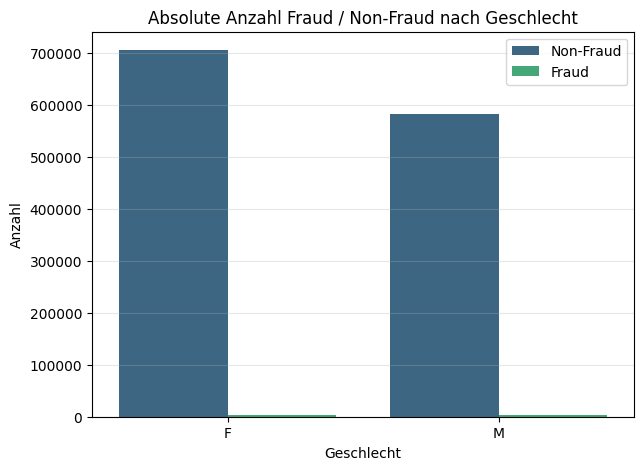

In [8]:
plt.figure(figsize=(7,5))
sns.countplot(data=ds, x="gender", hue="is_fraud", palette="viridis")
plt.title("Absolute Anzahl Fraud / Non-Fraud nach Geschlecht")
plt.xlabel("Geschlecht")
plt.ylabel("Anzahl")
plt.legend(["Non-Fraud", "Fraud"])
plt.grid(axis="y", alpha=0.3)

In [9]:

from scipy.stats import chi2_contingency
import math


# Fraud-Rate nach Geschlecht
p_M = ds[ds['gender'] == 'M']['is_fraud'].mean()
p_F = ds[ds['gender'] == 'F']['is_fraud'].mean()

risk_diff = p_M - p_F
print("Risk Difference (M - F):", risk_diff)

# Kontingenztafel
ct = pd.crosstab(ds['gender'], ds['is_fraud'])
print("\nKontingenztafel:\n", ct)

# Odds Ratio
a = ct.loc['M', 1]   # Fraud M
b = ct.loc['M', 0]   # Non-Fraud M
c = ct.loc['F', 1]   # Fraud F
d = ct.loc['F', 0]   # Non-Fraud F

odds_ratio = (a/b) / (c/d)
print("Odds Ratio (M vs F):", odds_ratio)

# Chi2 + Cramer's V
chi2, p, dof, expected = chi2_contingency(ct)
N = ct.sum().sum()
cramers_V = math.sqrt(chi2 / (N * (2 - 1)))  # k = 2 Kategorien
print("Cramér's V:", cramers_V)


Risk Difference (M - F): 0.0011646703093246774

Kontingenztafel:
 is_fraud       0     1
gender                
F         706128  3735
M         583041  3771
Odds Ratio (M vs F): 1.222785452501708
Cramér's V: 0.007631322322803248


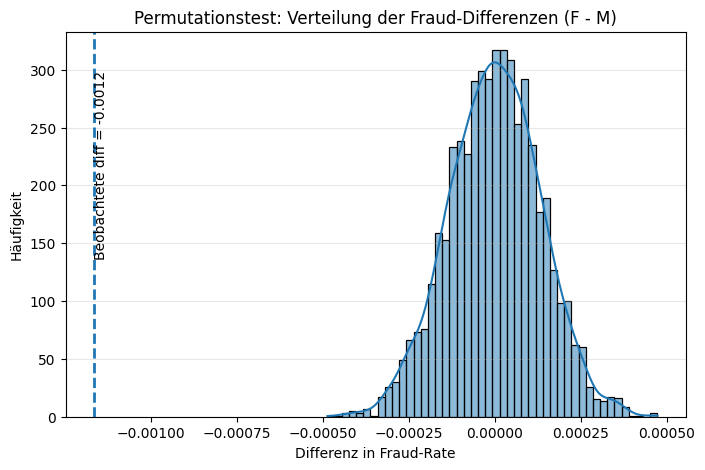

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(perm_diffs, bins="fd", kde=True)

# Beobachtete Differenz als Linie markieren
plt.axvline(observed_diff, linestyle="--", linewidth=2)

plt.title("Permutationstest: Verteilung der Fraud-Differenzen (F - M)")
plt.xlabel("Differenz in Fraud-Rate")
plt.ylabel("Häufigkeit")

# Annotation
plt.text(observed_diff, plt.ylim()[1]*0.9, 
         f"Beobachtete diff = {observed_diff:.4f}", 
         rotation=90, va='top')

plt.grid(axis="y", alpha=0.3)

95% Bootstrap-CI für Risk Difference: [0.0009, 0.0014]


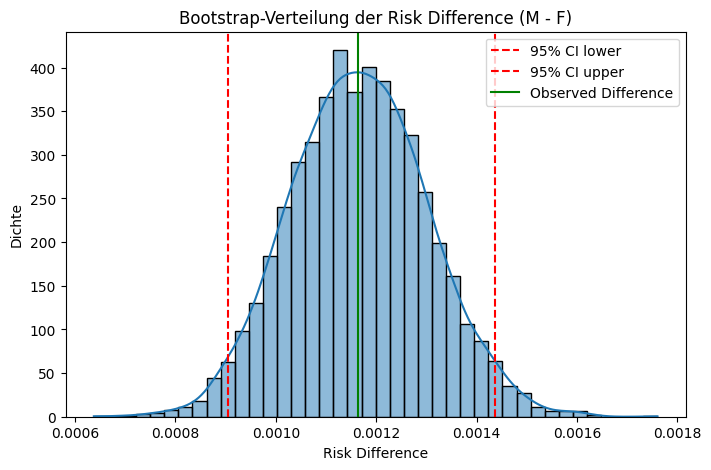

In [ ]:
# Arrays
fraud_M = ds[ds['gender']=="M"]["is_fraud"].values
fraud_F = ds[ds['gender']=="F"]["is_fraud"].values

n_boot = 5000
boot_diffs = np.zeros(n_boot)

rng = np.random.default_rng(42)

for i in range(n_boot):
    boot_M = rng.choice(fraud_M, size=len(fraud_M), replace=True)
    boot_F = rng.choice(fraud_F, size=len(fraud_F), replace=True)
    boot_diffs[i] = boot_M.mean() - boot_F.mean()

# 95% CI
lower = np.percentile(boot_diffs, 2.5)
upper = np.percentile(boot_diffs, 97.5)
print(f"95% Bootstrap-CI für Risk Difference: [{lower:.4f}, {upper:.4f}]")

# Plot
plt.figure(figsize=(8,5))
sns.histplot(boot_diffs, bins=40, kde=True)
plt.axvline(lower, color="red", linestyle="--", label="95% CI lower")
plt.axvline(upper, color="red", linestyle="--", label="95% CI upper")
plt.axvline(risk_diff, color="green", linestyle="-", label="Observed Difference")
plt.title("Bootstrap-Verteilung der Risk Difference (M - F)")
plt.xlabel("Risk Difference")
plt.ylabel("Dichte")
plt.legend()


### Interpretation


#### Interpretation der Signifikanz

Obwohl der p-Wert eine signifikante Differenz anzeigt, liegt dies vor allem an der sehr hohen Fallzahl (über 1,2 Mio. Transaktionen), die selbst kleinste Abweichungen statistisch "sichtbar" macht.

#### Interpretation der Odds Ratio

Der Wert von 1,22 besagt, dass die Chance für einen Betrug bei Männern etwa 22 % höher ist als bei Frauen.

#### Interpretation von Cramér's V

Mit einem Wert von 0,0076 ist die Effektstärke extrem gering. Das bedeutet, dass der statistische Zusammenhang zwischen Geschlecht und Betrug zwar existiert, aber praktisch fast vernachlässigbar klein ist.

#### Schlussfolgerung

Es gibt einen signifikanten Unterschied, wobei Männer ein leicht höheres Risiko aufweisen. Aufgrund der minimalen Effektstärke sollte dieses Merkmal in einem Vorhersagemodell jedoch deutlich schwächer gewichtet werden als der Betrag oder der Transaktionskanal.

## 4. Hypothese: Tageszeit (Nacht vs. Tag)

#### Fragestellung: Treten Betrugstransaktionen nachts (0–6 Uhr) signifikant häufiger auf als am Tag?

Nullhypothese $H_0$ : Es gibt keinen Zusammenhang zwischen der Tageszeit und dem Betrugsrisiko.

Alternativhypothese $H_1$: Nachtstunden weisen eine signifikant höhere Betrugsrate auf als die restliche Tageszeit.

#### Durchführung (Chi-Quadrat)

Zur Prüfung nutzen wir den Chi-Quadrat-Unabhängigkeitstest, da wir den Zusammenhang zwischen zwei kategorialen Variablen (Zeitfenster: Tag/Nacht und Status: Betrug/Kein Betrug) untersuchen. Zur Quantifizierung des Risikos berechnen wir zudem die Odds Ratio.

In [11]:
# Uhrzeit extrahieren
ds['hour'] = pd.to_datetime(ds['trans_date_trans_time']).dt.hour
ds['time_of_day'] = np.where(ds['hour'].between(0, 6), 'night', 'day')

# Kontingenztabelle
contingency = pd.crosstab(ds['time_of_day'], ds['is_fraud'])
chi2, p, dof, expected = chi2_contingency(contingency)

print(contingency)
print("Chi2:", chi2)
print("p-value:", p)

# Odds Ratio
a = contingency.loc['night', 1]
b = contingency.loc['day', 1]
c = contingency.loc['night', 0]
d = contingency.loc['day', 0]
odds_ratio = (a / b) / (c / d)
print("Odds Ratio:", odds_ratio)



is_fraud          0     1
time_of_day              
day          994712  4833
night        294457  2673
Chi2: 688.2915591507776
p-value: 1.0515068367612954e-151
Odds Ratio: 1.8683474247636542


/var/folders/cd/nv3twvx12gx_b15k3sbqkn300000gn/T/ipykernel_45558/1916118947.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud_ds['datetime'] = pd.to_datetime(fraud_ds['unix_time'], unit='s')
/var/folders/cd/nv3twvx12gx_b15k3sbqkn300000gn/T/ipykernel_45558/1916118947.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud_ds['hour'] = fraud_ds['datetime'].dt.hour


Text(0.5, 1.0, 'Histogramm der betrügerischen Transaktionen pro Stunde')

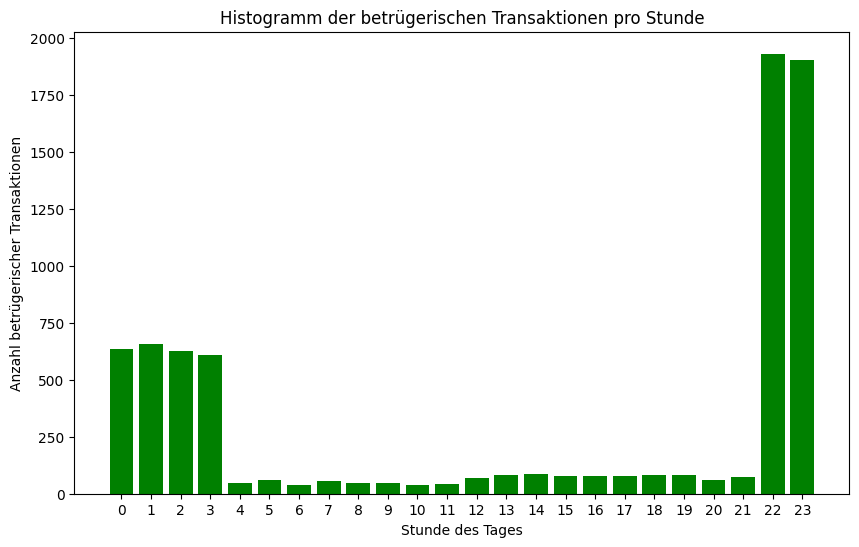

In [12]:
# Nur die betrügerischen Transaktionen auswählen
fraud_ds = ds[ds['is_fraud'] == 1]

# Unix-Zeit in datetime umwandeln
fraud_ds['datetime'] = pd.to_datetime(fraud_ds['unix_time'], unit='s')

# Stunde extrahieren
fraud_ds['hour'] = fraud_ds['datetime'].dt.hour

# Histogramm: Anzahl der betrügerischen Transaktionen pro Stunde
hour_counts = fraud_ds['hour'].value_counts().sort_index()

# Plot
plt.bar(hour_counts.index, hour_counts.values, color='green')
plt.xticks(range(24))  # alle Stunden von 0-23 anzeigen
plt.xlabel("Stunde des Tages")
plt.ylabel("Anzahl betrügerischer Transaktionen")
plt.title("Histogramm der betrügerischen Transaktionen pro Stunde")

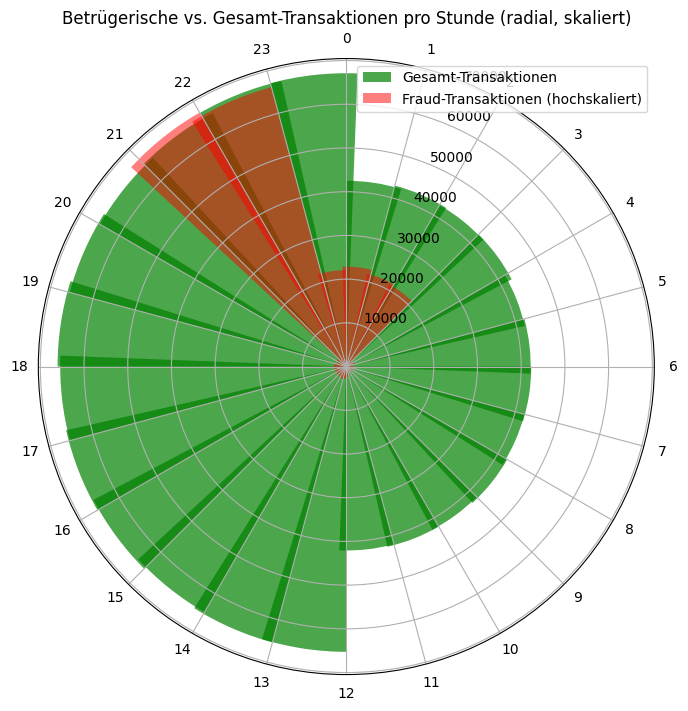

In [ ]:
# Stunden von 0 bis 23
hours = np.arange(24)

# Betrügerische Transaktionen pro Stunde
fraud_counts = fraud_ds['hour'].value_counts().sort_index()
fraud_values = [fraud_counts.get(h, 0) for h in hours]

# Gesamtanzahl aller Transaktionen pro Stunde
total_counts = ds['unix_time'].apply(lambda x: pd.to_datetime(x, unit='s').hour).value_counts().sort_index()
total_values = [total_counts.get(h, 0) for h in hours]

# Winkel für jede Stunde
angles = np.linspace(0, 2 * np.pi, 24, endpoint=False)

# Maximalwert der Gesamttransaktionen
max_total = max(total_values)

# Betrugswerte proportional hochskalieren
fraud_scaled = [v / max(fraud_values) * max_total for v in fraud_values]


fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'projection': 'polar'})
width = 0.3

# Grün vor Blau: Betrug zuerst
bars1 = ax.bar(angles + width/2, total_values, width=width, color='green', alpha=0.7, label='Gesamt-Transaktionen')
bars2 = ax.bar(angles - width/2, fraud_scaled, width=width, color='red', alpha=0.5, label='Fraud-Transaktionen (hochskaliert)')

ax.set_xticks(angles)
ax.set_xticklabels([str(h) for h in hours])
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_title("Betrügerische vs. Gesamt-Transaktionen pro Stunde (radial, skaliert)")
ax.legend(loc='upper right')

plt.show()

/var/folders/cd/nv3twvx12gx_b15k3sbqkn300000gn/T/ipykernel_45558/3937279395.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='time_of_day', y='is_fraud', data=fraud_rate_time, palette='Set2')


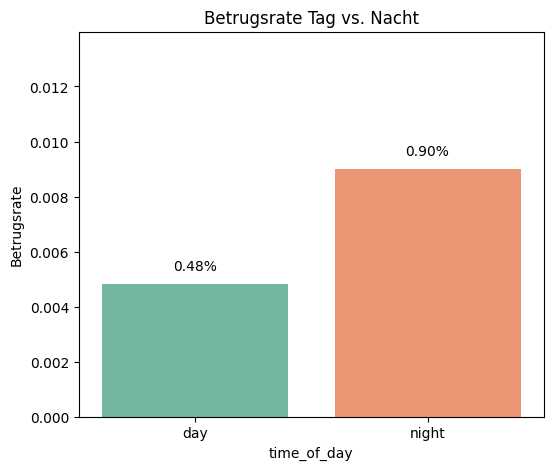

In [13]:
ds['hour'] = pd.to_datetime(ds['trans_date_trans_time']).dt.hour
ds['time_of_day'] = np.where(ds['hour'].between(0,6), 'night', 'day')

fraud_rate_time = ds.groupby('time_of_day')['is_fraud'].mean().reset_index()

plt.figure(figsize=(6,5))
sns.barplot(x='time_of_day', y='is_fraud', data=fraud_rate_time, palette='Set2')

for i, row in fraud_rate_time.iterrows():
    plt.text(i, row['is_fraud'] + 0.0005, f"{row['is_fraud']*100:.2f}%", ha='center')

plt.ylabel("Betrugsrate")
plt.title("Betrugsrate Tag vs. Nacht")
plt.ylim(0, fraud_rate_time['is_fraud'].max() + 0.005)
plt.show()


### Interpretation


#### Interpretation der Chi2-Statistik

Der extrem hohe Wert von ca. 688 weist auf eine massive Abweichung von der Gleichverteilung hin; die Zeit spielt eine zentrale Rolle beim 
Betrugsrisiko.

#### Interpretation des p-Werts

Der p-Wert ist praktisch null was die statistische Signifikanz zweifelsfrei bestätigt.

#### Interpretation der Odds Ratio

Der Wert von 1,87 besagt, dass die Chance für einen Betrug in der Nacht (0–6 Uhr) um 87 % höher ist als während des restlichen Tages.

#### Schlussfolgerung

Die Hypothese wird bestätigt. Die Nachtstunden sind eine "Hochrisiko-Zeit" für Betrug. In automatisierten Überwachungssystemen sollte die Uhrzeit daher ein stark gewichteter Faktor sein.

## 5. Hypothese: Bursting Behavior

#### Fragestellung: Führen Betrüger in kurzen Zeitabständen (innerhalb einer Stunde) signifikant mehr Transaktionen aus als reguläre Kunden?

Nullhypothese $H_0$ : Die durchschnittliche Anzahl an Transaktionen pro Stunde unterscheidet sich bei Betrugsfällen nicht von regulären Transaktionen.

Alternativhypothese $H_1$: Betrugsfälle zeigen ein "Bursting Behavior" (eine signifikant höhere Anzahl an Transaktionen pro Stunde).


#### Durchführung (T-Test & Cohen's d)

Zur Analyse wurde die Anzahl der Transaktionen pro Kunde und Stunde aggregiert. Ein T-Test für unabhängige Stichproben prüft die Signifikanz des Unterschieds. Zusätzlich wurde Cohen's d berechnet, um die praktische Relevanz (Effektstärke) des Unterschieds unabhängig von der Stichprobengröße zu bewerten.


/var/folders/cd/nv3twvx12gx_b15k3sbqkn300000gn/T/ipykernel_45558/2417282125.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  customer_day = ds.groupby(['cc_num', pd.Grouper(key='timestamp', freq='1H')]).agg(


Fraud bursts: (5307,)
Non-Fraud bursts: (1178990,)
t: 30.553769233485248
p-value: 4.9858048323434975e-189
Cohen's d: 0.5469170930235129
Mean Fraud: 1.4143583945732052
Mean Non-Fraud: 1.0934520224938296


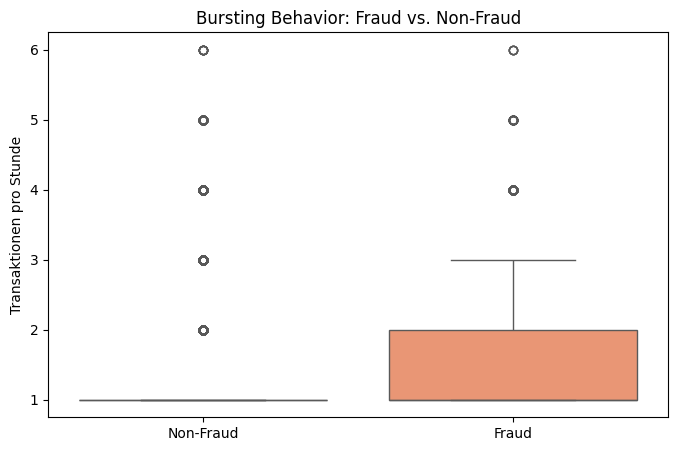

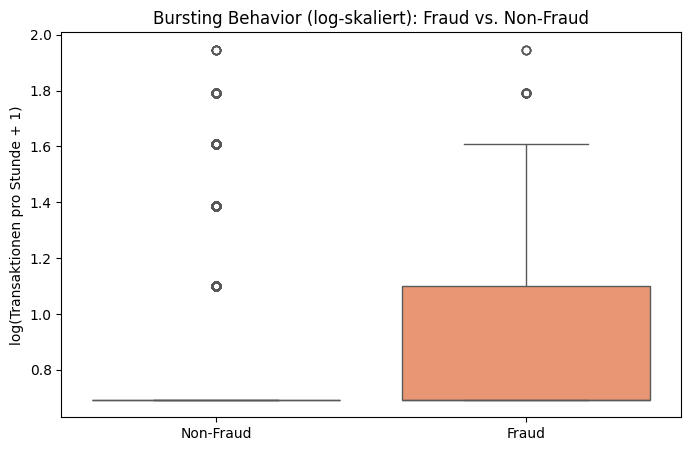

Text(0.5, 1.0, 'Bursting Behavior: Fraud vs. Non-Fraud (Violinplot)')

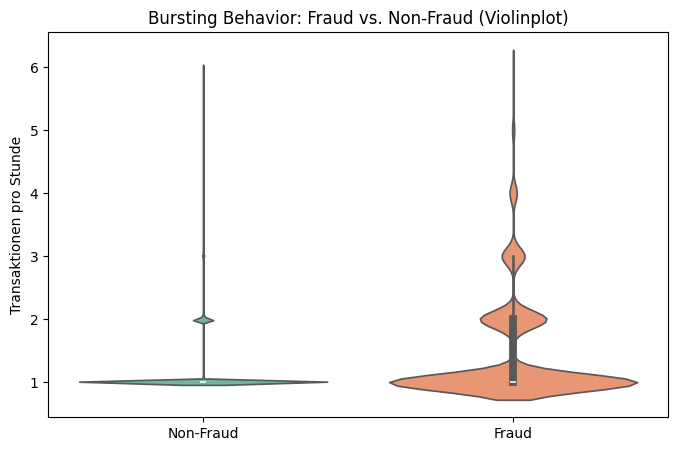

In [ ]:
from scipy.stats import ttest_ind

# Sicherstellen, dass Zeitstempel ein Datums-/Zeitwert ist
ds['timestamp'] = pd.to_datetime(ds['trans_date_trans_time'])

# Erstellen einer Tagesaggregation pro Kunde
customer_day = ds.groupby(['cc_num', pd.Grouper(key='timestamp', freq='1H')]).agg(
    transactions=('trans_num', 'count'),
    fraud=('is_fraud', 'max')  # 1, wenn eine Transaktion an diesem Tag betrügerisch ist

# Aufteilung in betrügerische und nicht betrügerische Bursts
burst_fraud = customer_day[customer_day['fraud']==1]['transactions']
burst_nonfraud = customer_day[customer_day['fraud']==0]['transactions']

print("Fraud bursts:", burst_fraud.shape)
print("Non-Fraud bursts:", burst_nonfraud.shape)

# Statistischer Test
t_stat, p_val = ttest_ind(burst_fraud, burst_nonfraud, equal_var=False)
d = (burst_fraud.mean() - burst_nonfraud.mean()) / np.sqrt((burst_fraud.std()**2 + burst_nonfraud.std()**2)/2)

print("t:", t_stat)
print("p-value:", p_val)
print("Cohen's d:", d)
print("Mean Fraud:", burst_fraud.mean())
print("Mean Non-Fraud:", burst_nonfraud.mean())
 
# Boxplot (mit Ausreißerbegrenzung)
plt.figure(figsize=(8,5))
df_box = pd.DataFrame({'Non-Fraud': burst_nonfraud, 'Fraud': burst_fraud})
sns.boxplot(data=df_box, palette='Set2')
plt.xticks([0,1], ['Non-Fraud', 'Fraud'])
plt.ylabel("Transaktionen pro Stunde")
plt.title("Bursting Behavior: Fraud vs. Non-Fraud")
plt.show()

# Log-transformierter Boxplot (zeigt Unterschiede besser bei Schiefe)
plt.figure(figsize=(8,5))
df_box = pd.DataFrame({'Non-Fraud': np.log1p(burst_nonfraud), 'Fraud':  np.log1p(burst_fraud)})
sns.boxplot(data=df_box, palette='Set2')
plt.xticks([0,1], ['Non-Fraud', 'Fraud'])
plt.ylabel("log(Transaktionen pro Stunde + 1)")
plt.title("Bursting Behavior (log-skaliert): Fraud vs. Non-Fraud")
plt.show()

# Violinplot / Dichteplot
plt.figure(figsize=(8,5))
df_box = pd.DataFrame({'Non-Fraud': burst_nonfraud, 'Fraud': burst_fraud})
sns.violinplot(data=df_box, palette='Set2')
plt.xticks([0,1], ['Non-Fraud', 'Fraud'])
plt.ylabel("Transaktionen pro Stunde")
plt.title("Bursting Behavior: Fraud vs. Non-Fraud (Violinplot)")

### Interpretation


#### Interpretation der t-Statistik

Ein Wert von über 30 unterstreicht, dass der beobachtete Unterschied in der Kauffrequenz absolut kein Zufallsprodukt ist.

#### Interpretation der Odds Ratio

Der Wert von 1,22 besagt, dass die Chance für einen Betrug bei Männern etwa 22 % höher ist als bei Frauen.

#### Interpretation von Cohen's d

Im Gegensatz zum Geschlechts-Vergleich (Hypothese 3) ist der Effekt hier mit 0.55 "mittelstark". Das bedeutet, der Unterschied ist nicht nur statistisch vorhanden, sondern auch in der Praxis deutlich spürbar und relevant für die Vorhersage.

#### Interpretation des p-Werts

Der p-Wert ist vernachlässigbar klein, was die Alternativhypothese zweifelsfrei stützt.

#### Schlussfolgerung

Betrüger agieren oft in "Salven", um in kürzester Zeit möglichst viel Kapital abzugreifen, bevor die Karte gesperrt wird. Die Anzahl der Transaktionen in einem kurzen Zeitfenster (z.B. 1 Stunde) ist daher ein hocheffektives Warnsignal für Betrugserkennungssysteme.

**6.Hypothese: Bestimmte Categories weisen höhere Fraud-Raten auf**

## 6. Hypothese: Warenkategorien

#### Fragestellung: Gibt es bestimmte Ausgabenkategorien, in denen Betrugsfälle signifikant häufiger auftreten als in anderen?

Nullhypothese $H_0$ : Die Betrugsrate ist über alle Kategorien hinweg gleich verteilt (kein Zusammenhang).

Alternativhypothese $H_1$: Es gibt signifikante Unterschiede in den Betrugsraten zwischen den verschiedenen Warenkategorien.


#### Durchführung (Chi-Quadrat-Test & Cramér's V)

Zur Untersuchung des Zusammenhangs zwischen der kategorialen Variable "Category" und dem Betrugsstatus wurde ein Chi-Quadrat-Unabhängigkeitstest durchgeführt. Da die Kategorien sehr vielfältig sind, nutzen wir Cramér's V, um die Stärke des Zusammenhangs (Effektstärke) über alle Kategorien hinweg zu bewerten.


In [15]:
contingency_cat = pd.crosstab(ds['category'], ds['is_fraud'])
chi2, p, dof, expected = chi2_contingency(contingency_cat)

print("Chi2:", chi2)
print("p-value:", p)

# Effektgröße: Cramér's V
n = contingency_cat.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(contingency_cat.shape)-1)))
print("Cramér's V:", cramers_v)


Chi2: 6486.003269983207
p-value: 0.0
Cramér's V: 0.07072500922873913


/var/folders/cd/nv3twvx12gx_b15k3sbqkn300000gn/T/ipykernel_45558/2083098101.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='category', y='is_fraud', data=fraud_rate_cat, palette='Set3')


(0.0, 0.022561485703740915)

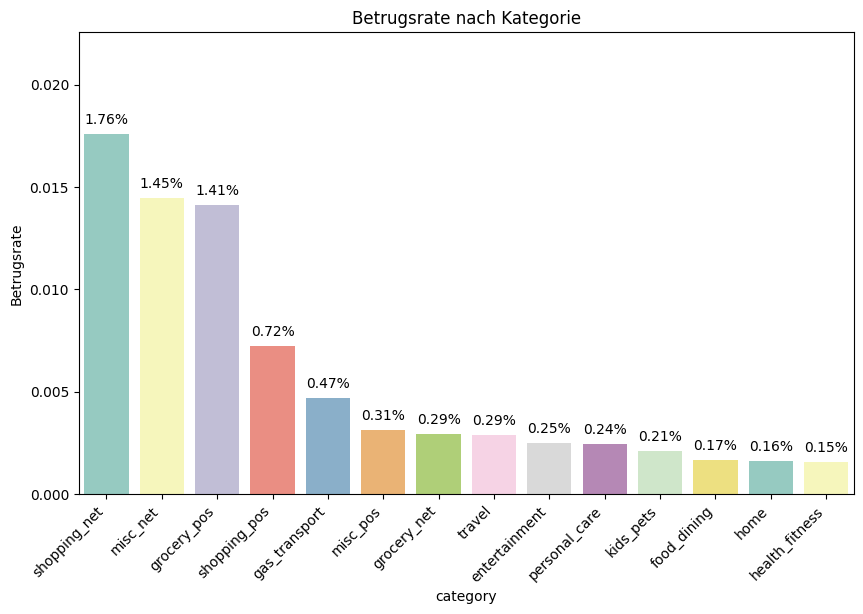

In [16]:
fraud_rate_cat = ds.groupby('category')['is_fraud'].mean().sort_values(ascending=False).reset_index()


sns.barplot(x='category', y='is_fraud', data=fraud_rate_cat, palette='Set3')
plt.xticks(rotation=45, ha='right')

for i, row in fraud_rate_cat.iterrows():
    plt.text(i, row['is_fraud'] + 0.0005, f"{row['is_fraud']*100:.2f}%", ha='center')

plt.ylabel("Betrugsrate")
plt.title("Betrugsrate nach Kategorie")
plt.ylim(0, fraud_rate_cat['is_fraud'].max() + 0.005)


### Interpretation


#### Interpretation der Chi2-Statistik

Der extrem hohe Wert von über 6400 zeigt, dass die Kategorie ein massiver Einflussfaktor ist. Die Unterschiede zwischen den Kategorien sind gewaltig.

#### Interpretation des p-Werts

Ein p-Wert von p < 0.001 belegt, dass die Unterschiede zwischen den Kategorien (z. B. hohe Raten bei Online-Shopping vs. niedrige Raten bei Lebensmitteln) statistisch absolut belastbar sind.

#### Interpretation von Cramér's V

Obwohl der Zusammenhang höchst signifikant ist, gilt der Wert von 0.07 als kleiner Effekt. Das bedeutet, dass die Kategorie zwar wichtig ist, aber nicht das alleinige Merkmal zur Identifizierung von Betrug sein kann.

#### Schlussfolgerung

Die Hypothese wird bestätigt. Betrüger bevorzugen spezifische Kategorien (oft solche mit leicht wiederverkäuflichen Waren oder anonymen Dienstleistungen). Für ein Betrugserkennungsmodell ist die Kategorie ein unverzichtbares Merkmal.